In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, f1_score, make_scorer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

## The Data

In [2]:
df_weed = pd.read_csv('./Data/cannabis_full.csv')
df_weed.head()

,Strain,Type,Rating,Effects,Flavor,Creative,Energetic,Tingly,Euphoric,Relaxed,...,Ammonia,Minty,Tree,Fruit,Butter,Pineapple,Tar,Rose,Plum,Pear
0,100-Og,hybrid,4.0,"Creative,Energetic,Tingly,Euphoric,Relaxed","Earthy,Sweet,Citrus",1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,98-White-Widow,hybrid,4.7,"Relaxed,Aroused,Creative,Happy,Energetic","Flowery,Violet,Diesel",1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1024,sativa,4.4,"Uplifted,Happy,Relaxed,Energetic,Creative","Spicy/Herbal,Sage,Woody",1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,13-Dawgs,hybrid,4.2,"Tingly,Creative,Hungry,Relaxed,Uplifted","Apricot,Citrus,Grapefruit",1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,24K-Gold,hybrid,4.6,"Happy,Relaxed,Euphoric,Uplifted,Talkative","Citrus,Earthy,Orange",0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
len(df_weed[df_weed.isna().any(axis=1)])

160

In [4]:
df_weed.dropna(inplace=True)

## Part One: Binary Classification

In [5]:
df_weed_bin = df_weed[df_weed['Type'].isin(['sativa', 'indica'])]
df_weed_bin.head()

,Strain,Type,Rating,Effects,Flavor,Creative,Energetic,Tingly,Euphoric,Relaxed,...,Ammonia,Minty,Tree,Fruit,Butter,Pineapple,Tar,Rose,Plum,Pear
2,1024,sativa,4.4,"Uplifted,Happy,Relaxed,Energetic,Creative","Spicy/Herbal,Sage,Woody",1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,303-Og,indica,4.2,"Relaxed,Happy,Euphoric,Uplifted,Giggly","Citrus,Pungent,Earthy",0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,3D-Cbd,sativa,4.6,"Uplifted,Focused,Happy,Talkative,Relaxed","Earthy,Woody,Flowery",0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,3X-Crazy,indica,4.4,"Relaxed,Tingly,Happy,Euphoric,Uplifted","Earthy,Grape,Sweet",0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,5Th-Element,indica,4.4,"Relaxed,Focused,Euphoric,Uplifted,Aroused","Earthy,Woody,Pine",0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
X = df_weed_bin.drop(columns=['Type', 'Strain', 'Effects', 'Flavor'])
y = df_weed_bin['Type']

df_weed_bin['Type'].value_counts()

Type
indica    659
sativa    409
Name: count, dtype: int64

I will be evaluating all my models based on F1 score. I chose this metric because there is a slight class imbalance between the 2 strains, and F1 captures a balance of precision and recall.

In [7]:
def model_metrics(pipeline, params, X, y):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        grid_search = GridSearchCV(pipeline, params, cv=5, scoring='f1_weighted')
        grid_search.fit(X, y)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X)

    print(f"f1: {f1_score(y, y_pred, average='weighted')}")

    cm = confusion_matrix(y, y_pred)
    class_labels = sorted(y.unique())

    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    return

ct = ColumnTransformer(
    [("num", StandardScaler(), ['Rating'])],
    remainder="passthrough"
)

### LDA

f1: 0.8825241609911342


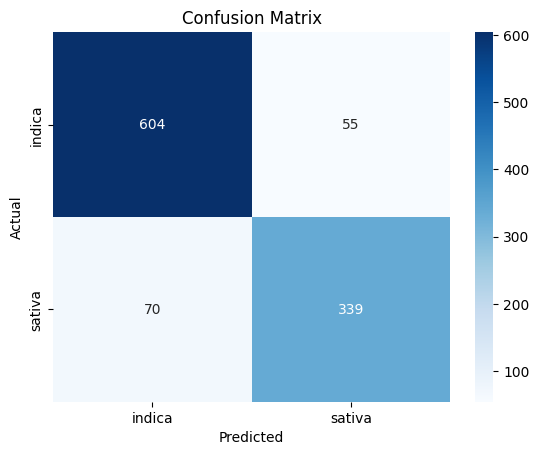

In [8]:
pipeline_lda = Pipeline(
     [("preprocessing", ct),
      ("lda", LinearDiscriminantAnalysis())]
)

params_lda = {
    "lda__solver": ['svd', 'lsqr', 'eigen'],
    "lda__shrinkage": [None, 'auto', 0.01, 0.1, 0.5, 0.9, 1]
}

model_metrics(pipeline_lda, params_lda, X, y)

### QDA

f1: 0.8977692112577214


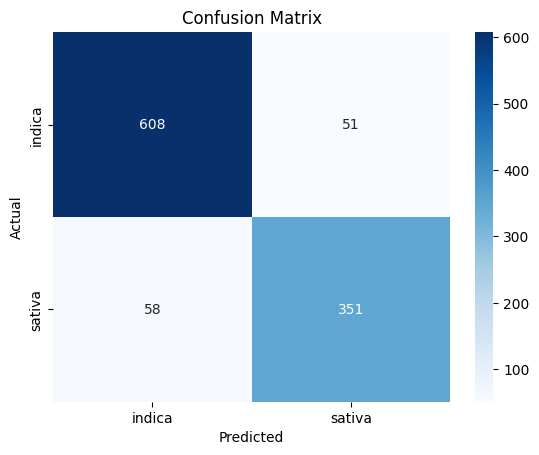

In [9]:
pipeline_qda = Pipeline(
     [("preprocessing", ct),
      ("qda", QuadraticDiscriminantAnalysis())]
)

params_qda = {
    "qda__reg_param": [0, 0.001, 0.01, 0.1, 0.5, 0.9, 1]
}

model_metrics(pipeline_qda, params_qda, X, y)

### SVC

f1: 0.8814899835161137


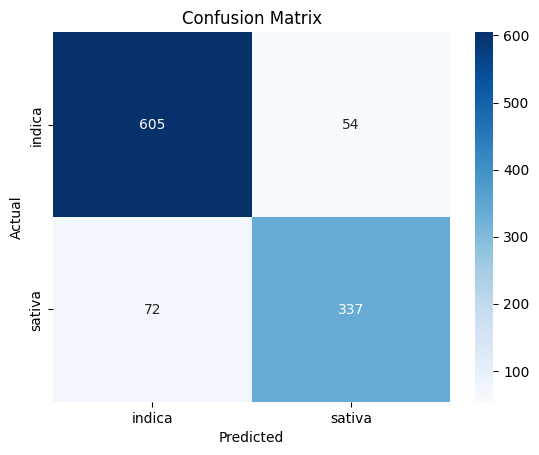

In [10]:
pipeline_svc = Pipeline(
     [("preprocessing", ct),
      ("svc", SVC())]
)

params_svc = {
    "svc__C": [0.1, 1, 10, 100],
    "svc__kernel": ['linear', 'rbf', 'sigmoid'],
    "svc__gamma": ['scale', 'auto']
}

model_metrics(pipeline_svc, params_svc, X, y)

### SVM

f1: 0.9540202299305892


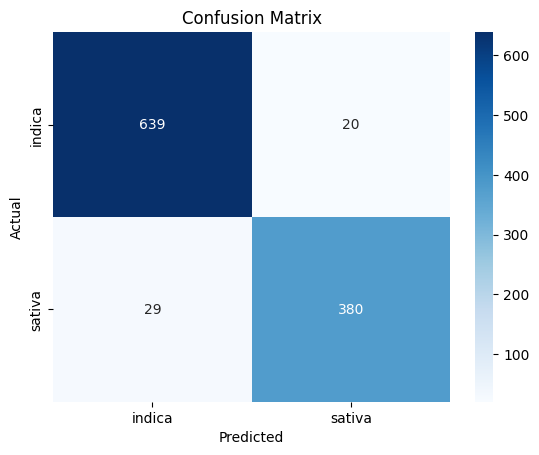

In [11]:
pipeline_svm = Pipeline([
    ("preprocessing", ct),
    ("svm", SVC(kernel='poly'))
])

params_svm = {
    "svm__C": [0.1, 1, 10, 100],
    "svm__degree": [2, 3, 4],
    "svm__gamma": ['scale', 'auto']
}

model_metrics(pipeline_svm, params_svm, X, y)

## Part Two: Natural Multiclass

In [12]:
X = df_weed.drop(columns=['Type', 'Strain', 'Effects', 'Flavor'])
y = df_weed['Type']

df_weed['Type'].value_counts()

Type
hybrid    1123
indica     659
sativa     409
Name: count, dtype: int64

### Q1

In [13]:
pipeline_tree = ImbPipeline(
    [("preprocessing", ct),
     #("smote", SMOTE()),
     ("tree", DecisionTreeClassifier())]
)

params_tree = {
    'tree__max_depth': [3, 5, 10, None],
    'tree__min_samples_split': [2, 5, 10],
    'tree__min_samples_leaf': [1, 2, 4],
    'tree__max_features': ['auto', 'sqrt', 'log2', None]
}

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    grid_search = GridSearchCV(pipeline_tree, params_tree, cv=5, scoring='f1')
    grid_search.fit(X, y)

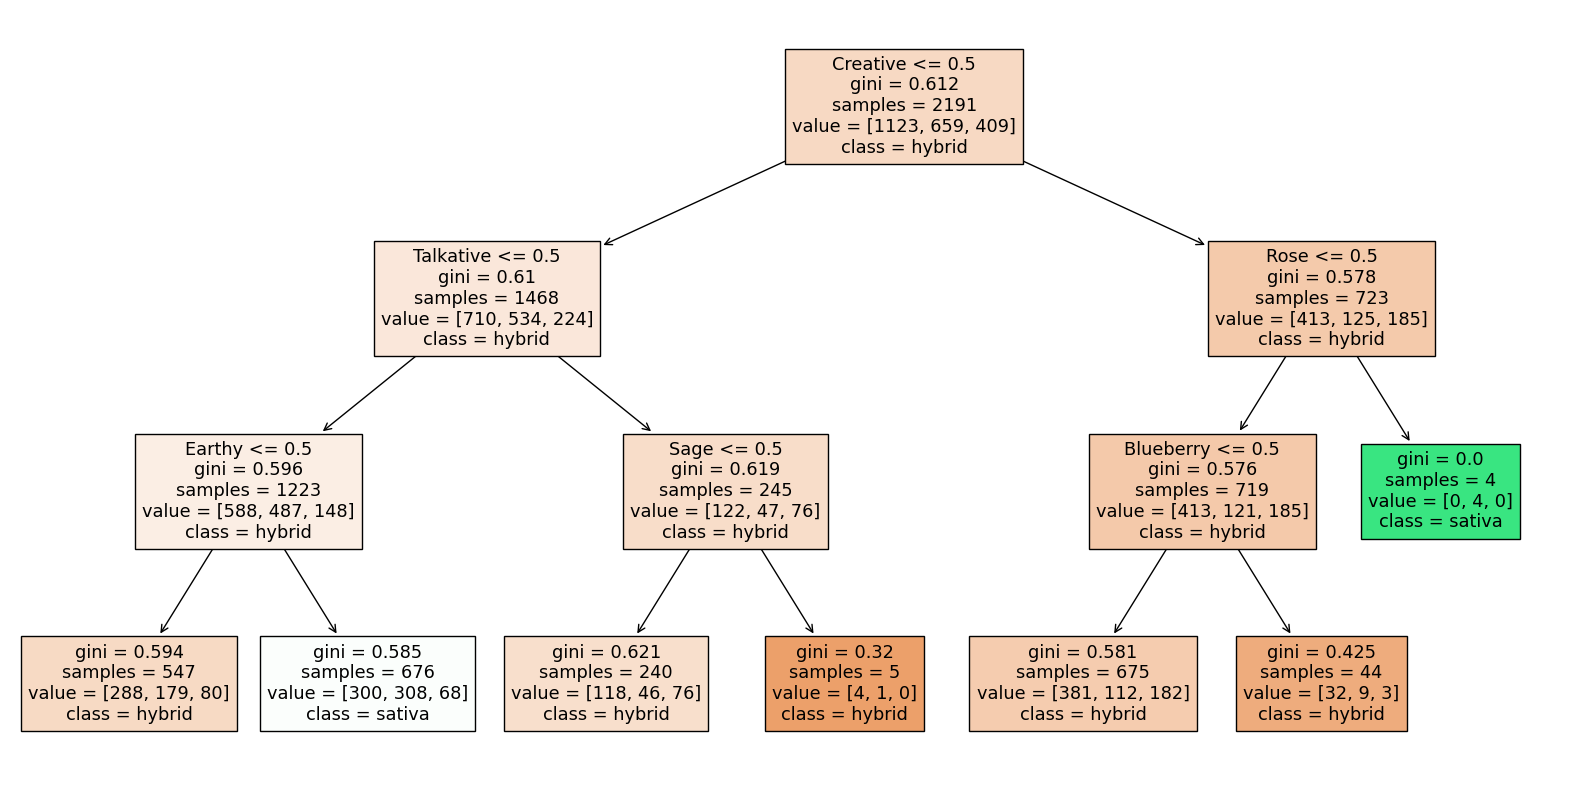

In [14]:
best_tree = grid_search.best_estimator_.named_steps['tree']
class_names = y.unique()

plt.figure(figsize=(20,10))
plot_tree(best_tree, filled=True, feature_names=X.columns, class_names=class_names)
plt.show()

In [15]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X)
print(f"f1: {f1_score(y, y_pred, average='weighted')}")

f1: 0.4604633542567274


At first, I tried to use SMOTE to deal with class imbalance, but got a significantly worse f1 score. This is probably still due to class imbalance since I'm not splitting the testing data. But the final tree selected has a heavy favoritism of hybrid (class imbalance again), and doesn't even predict indica. It seems like this tree's most important decision factor is creative effect.

### Q2

f1: 0.6422745437848254


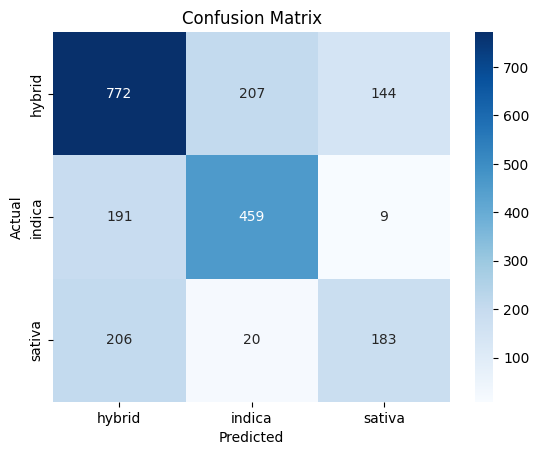

In [16]:
model_metrics(pipeline_lda, params_lda, X, y)

f1: 0.6779921844562153


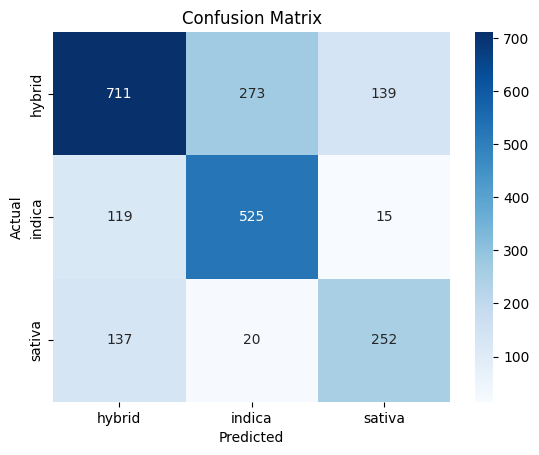

In [17]:
model_metrics(pipeline_qda, params_qda, X, y)

f1: 0.6377883290832486


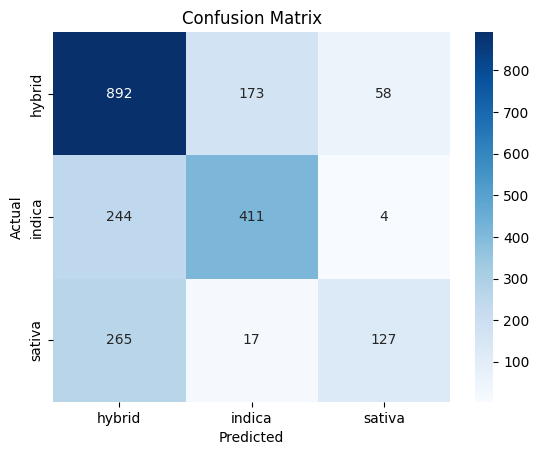

In [18]:
pipeline_knn = Pipeline(
    [("preprocessing", ct),
     ("knn", KNeighborsClassifier())]
)

params_knn = {
    'knn__n_neighbors': [3, 5, 7, 10, 15],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan', 'minkowski']
}

model_metrics(pipeline_knn, params_knn, X, y)

### Q3

Hybrids were by far the hardest for my models to identify, whether it incorrectly identifying a hybrid as sativa or indica, or incorrectly identifying a sativa or indica as a hybrid.

## Part Three: Multiclass from Binary

In [19]:
y_ind = (y == 'indica').astype(int)
y_sat = (y == 'sativa').astype(int)
y_hyb = (y == 'hybrid').astype(int) 

### Q1

In [20]:
pipeline_log = Pipeline(
    [("preprocessing", ct),
     ("log", LogisticRegression())]
)

params_log = {
    'log__C': [0.01, 0.1, 1, 10, 100]
}

f1: 0.7898472551234924


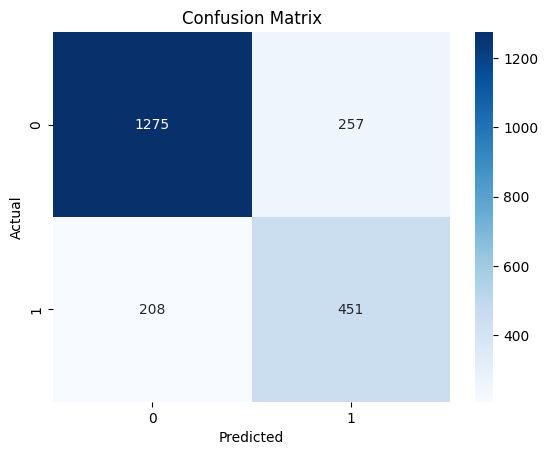

f1: 0.8030070425264656


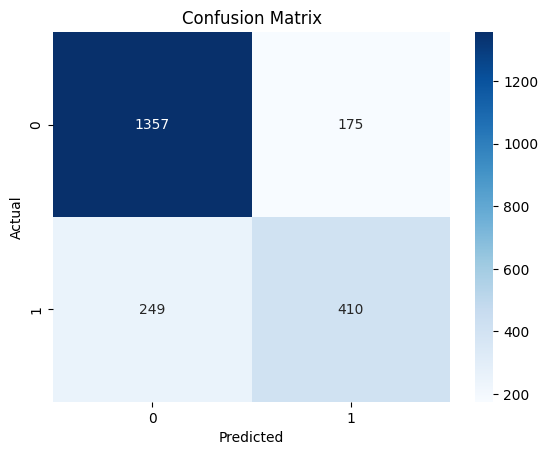

In [21]:
model_metrics(pipeline_svc, params_svc, X, y_ind)
model_metrics(pipeline_log, params_log, X, y_ind)

f1: 0.8831813394892382


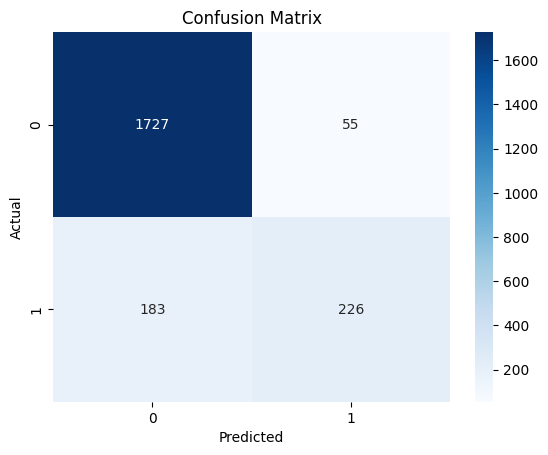

f1: 0.8213782845008378


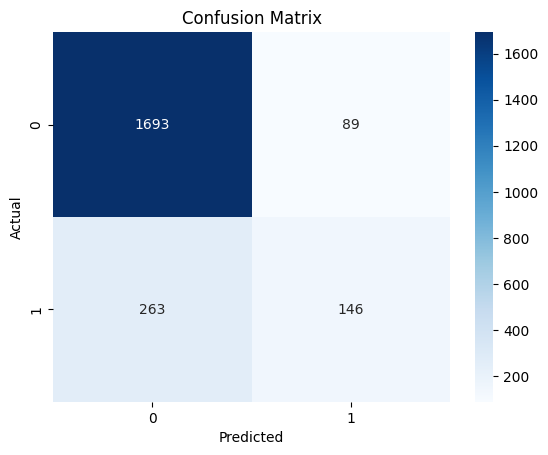

In [22]:
model_metrics(pipeline_svc, params_svc, X, y_sat)
model_metrics(pipeline_log, params_log, X, y_sat)

f1: 0.706321378526777


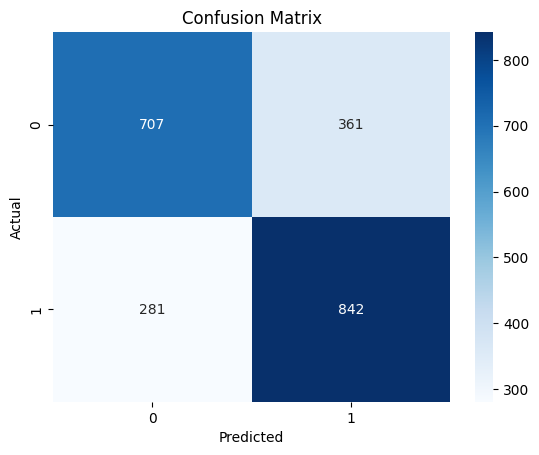

f1: 0.6449541221845714


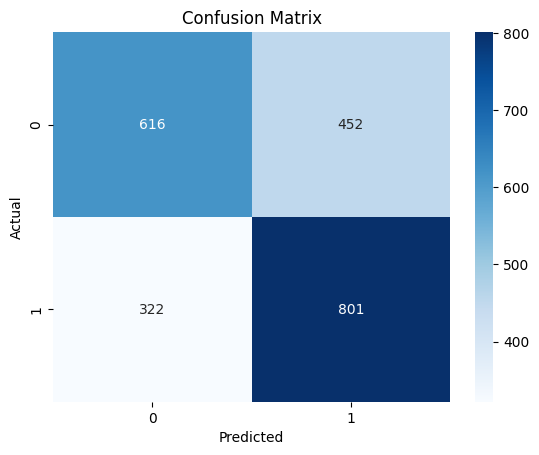

In [23]:
model_metrics(pipeline_svc, params_svc, X, y_hyb)
model_metrics(pipeline_log, params_log, X, y_hyb)

### Q2

Worst: Logistic hybrid vs non\
Best: SVC sativa vs non\
This makes sense as it was hard for previous models to pick up on hybrids

### Q3

In [24]:
X_indsat = df_weed_bin.drop(columns=['Type', 'Strain', 'Effects', 'Flavor'])
y_indsat = df_weed_bin['Type']

df_weed_bin = df_weed[df_weed['Type'].isin(['indica', 'hybrid'])]
X_indhyb = df_weed_bin.drop(columns=['Type', 'Strain', 'Effects', 'Flavor'])
y_indhyb = df_weed_bin['Type']

df_weed_bin = df_weed[df_weed['Type'].isin(['hybrid', 'sativa'])]
X_hybsat = df_weed_bin.drop(columns=['Type', 'Strain', 'Effects', 'Flavor'])
y_hybsat = df_weed_bin['Type']

f1: 0.8814899835161137


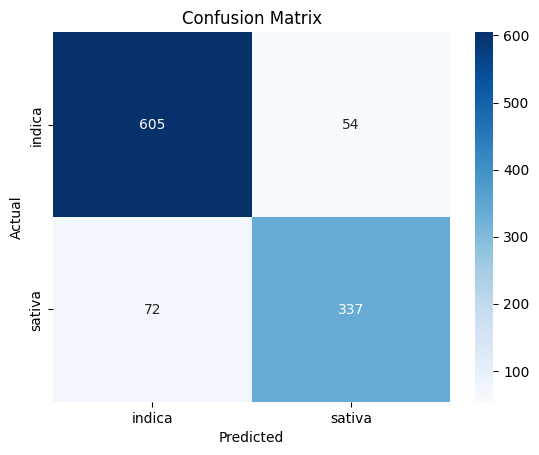

f1: 0.8831785931000755


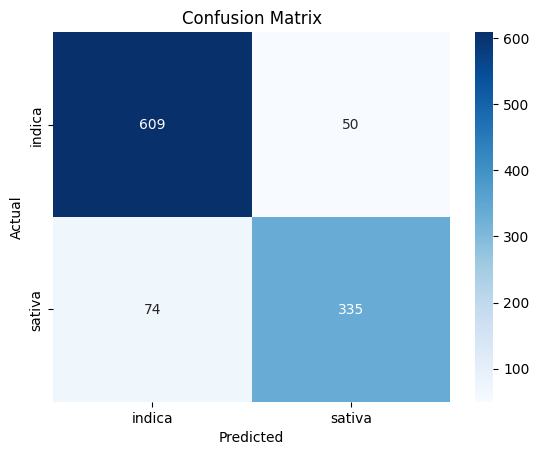

In [25]:
model_metrics(pipeline_svc, params_svc, X_indsat, y_indsat)
model_metrics(pipeline_log, params_log, X_indsat, y_indsat)

f1: 0.7595526235849286


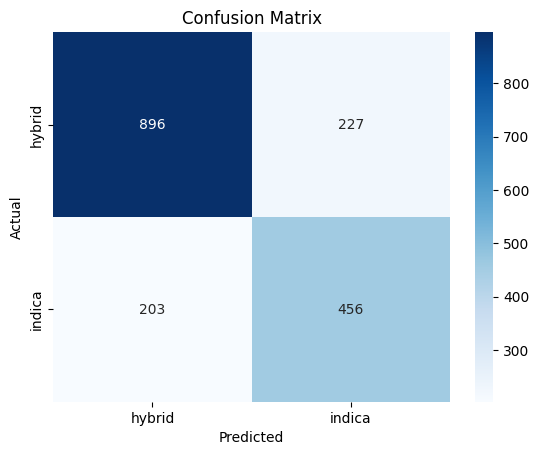

f1: 0.7664177347151893


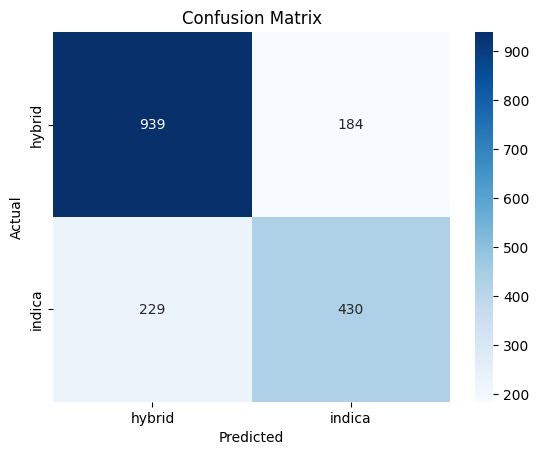

In [26]:
model_metrics(pipeline_svc, params_svc, X_indhyb, y_indhyb)
model_metrics(pipeline_log, params_log, X_indhyb, y_indhyb)

f1: 0.8430327947059139


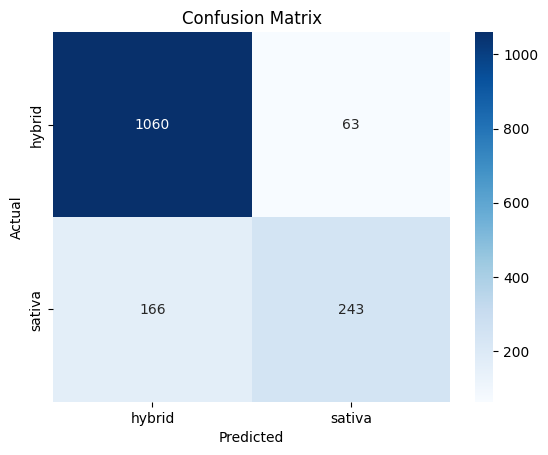

f1: 0.7474554506680742


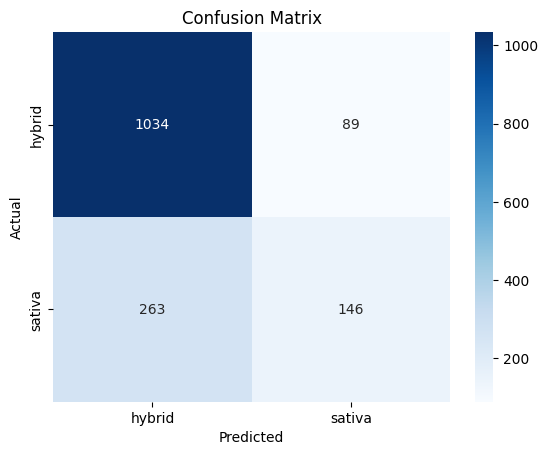

In [27]:
model_metrics(pipeline_svc, params_svc, X_hybsat, y_hybsat)
model_metrics(pipeline_log, params_log, X_hybsat, y_hybsat)

### Q4

Worst: log hybrid vs sativa\
Best: log indica vs sativa\
This makes sense as it was hard for previous models to pick up on hybrids

### Q5

Log: OvR\
SVC: OvO